# Проект: Прогнозирование стоимости медицинской страховки

> ### Цель проекта
> Разработать модель машинного обучения для прогнозирования стоимости медицинской страховки на основе характеристик клиента.
>
> ---
>
> ### Описание данных
> Для анализа предоставлен датасет со следующими признаками:
> - **age**: возраст
> - **sex**: пол
> - **bmi**: индекс массы тела
> - **children**: количество детей
> - **smoker**: факт курения
> - **region**: регион проживания
>
> **Целевая переменная**: `charges` (стоимость страховки).

### 1. Конфигурация и импорт библиотек

In [ ]:
# библиотеки для работы с данными и визуализации
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Компоненты из Scikit-learn для построения модели
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score

# Модели и инструменты для интерпретации
import lightgbm as lgb
import shap

# Константы и настройки
DATA_PATH = 'insurance.csv'
# Выношу числа в константы для лёгкого управления и читаемости
RANDOM_STATE = 42
TEST_SIZE = 0.2

# Настраиваю стиль для всех графиков в проекте
sns.set_style('whitegrid')

c:\Users\a84405958\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Загрузка и первичный анализ данных

In [ ]:
# Загружаю данные из файла, используя try-except для обработки возможной ошибки
try:
    df = pd.read_csv(DATA_PATH)

    print("Первые 5 строк данных")
    display(df.head()) # display() выглядит лучше, чем print() :)
    print("\n" + "="*50 + "\n")

    print("Общая информация: типы данных и наличие пропусков")
    df.info()
    print("\n" + "="*50 + "\n")
    
    print("Основные статистические показатели для числовых столбцов")
    display(df.describe())

except FileNotFoundError:
    print(f"Ошибка: Файл не найден по пути: {DATA_PATH}")

Первые 5 строк данных


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520




Общая информация: типы данных и наличие пропусков
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Основные статистические показатели для числовых столбцов


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### 3. Визуальный анализ данных (EDA)

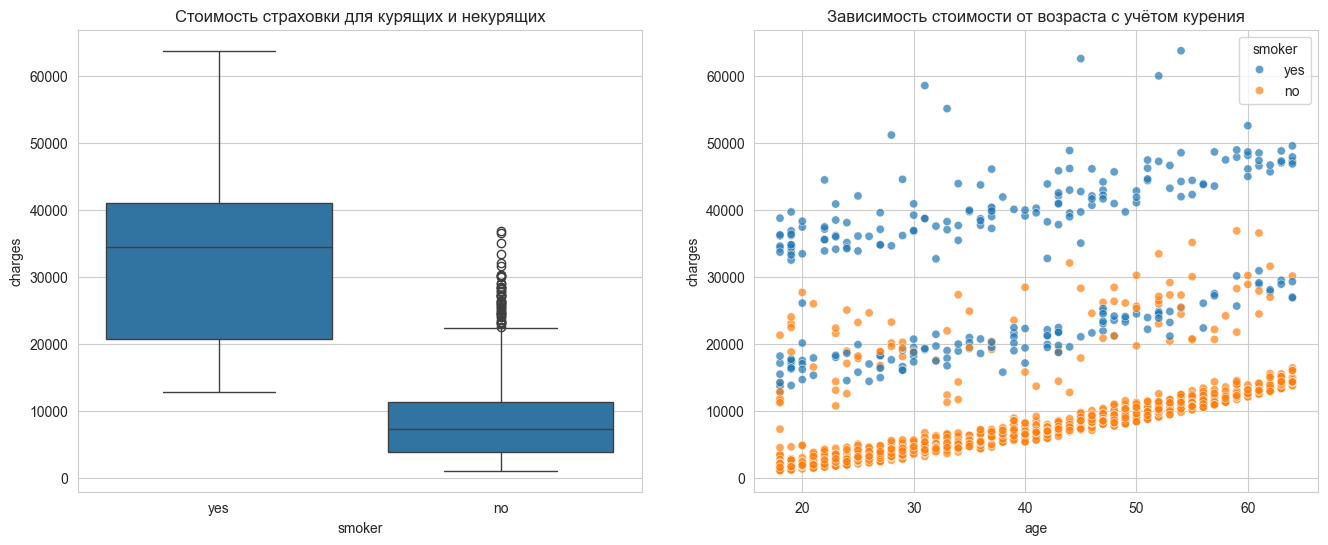

In [ ]:
plt.figure(figsize=(16, 6))# Создаю фигуру для двух графиков рядом

# График 1: Сравниваю распределение стоимости для курящих и некурящих
plt.subplot(1, 2, 1)
sns.boxplot(x='smoker', y='charges', data=df)
plt.title('Стоимость страховки для курящих и некурящих')

# График 2: Изучаю зависимость стоимости от возраста, разделяя по статусу курения
plt.subplot(1, 2, 2)
sns.scatterplot(x='age', y='charges', data=df, hue='smoker', alpha=0.7)
plt.title('Зависимость стоимости от возраста с учётом курения')

plt.show()

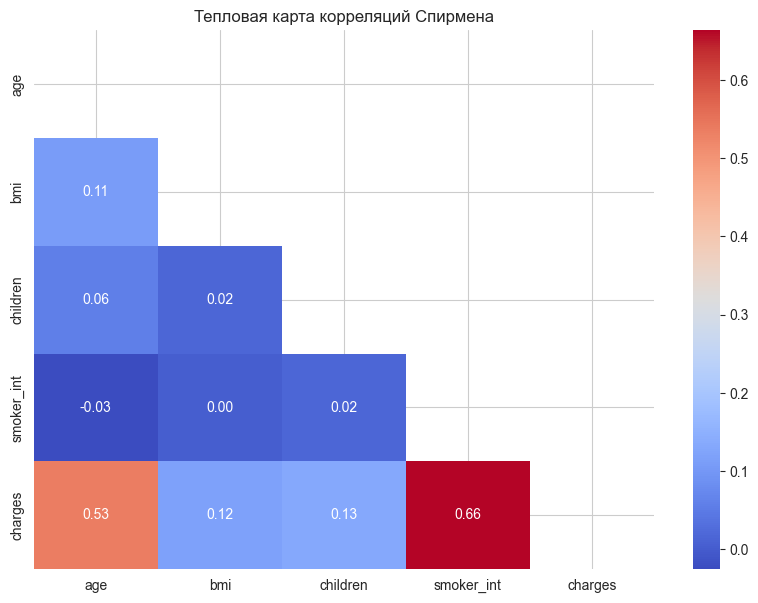

In [ ]:
# Тепловая карта корреляций
# Создаю временную копию для добавления числового признака курения
df_encoded = df.copy()
df_encoded['smoker_int'] = df_encoded['smoker'].map({'yes': 1, 'no': 0})

# Использую корреляцию Спирмена, так как она лучше улавливает нелинейные монотонные связи
spearman_corr = df_encoded[['age', 'bmi', 'children', 'smoker_int', 'charges']].corr(method='spearman')

# Создаю маску, чтобы убрать дублирующую верхнюю часть карты для лучшей читаемости
mask = np.triu(np.ones_like(spearman_corr, dtype=bool))

plt.figure(figsize=(10, 7))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt='.2f', mask=mask)
plt.title('Тепловая карта корреляций Спирмена')
plt.show()

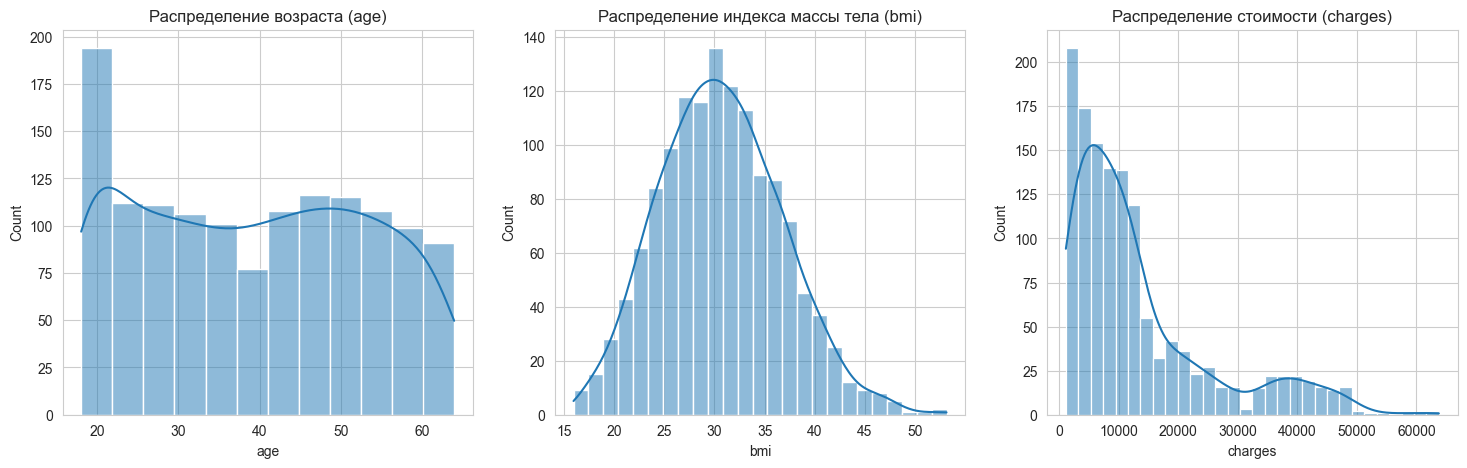

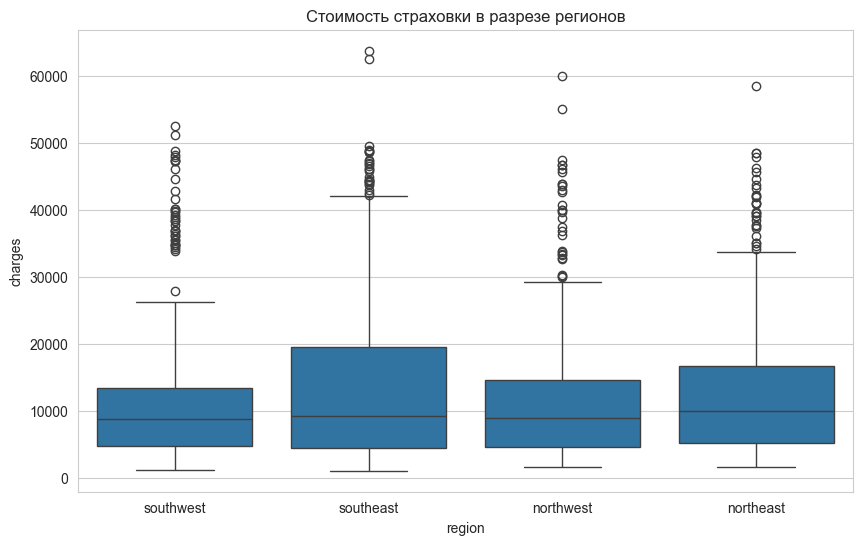

In [5]:
# Дополнительный визуальный анализ
plt.figure(figsize=(18, 5))

# Гистограмма для оценки распределения возраста
plt.subplot(1, 3, 1)
sns.histplot(df['age'], kde=True)
plt.title('Распределение возраста (age)')

# Гистограмма для оценки распределения ИМТ
plt.subplot(1, 3, 2)
sns.histplot(df['bmi'], kde=True)
plt.title('Распределение индекса массы тела (bmi)')

# Гистограмма для оценки распределения стоимости страховки
plt.subplot(1, 3, 3)
sns.histplot(df['charges'], kde=True)
plt.title('Распределение стоимости (charges)')

plt.show()

# Boxplot для анализа стоимости по регионам
plt.figure(figsize=(10, 6))
sns.boxplot(x='region', y='charges', data=df)
plt.title('Стоимость страховки в разрезе регионов')
plt.show()

> **Выводы из дополнительного анализа:**
> * Распределения `age` и `bmi` близки к нормальному.
> * Распределение `charges` (стоимость) сильно скошено вправо. Это говорит о наличии небольшого числа клиентов с очень высокой стоимостью страховки. Логарифмирование этой переменной могло бы улучшить качество **линейных** моделей, но не **деревянных** моделей (как LightGBM).
> * Анализ по регионам не показывает сильных различий в медианной стоимости страховки, что подтверждает низкую важность этого признака.

In [ ]:
# ______Feature Engineering________
# Создаю новые признаки, чтобы потенциально улучшить точность модели.

# 1. Категориальный признак ожирения. ИМТ > 30 является медицинским порогом.
df['is_obese'] = (df['bmi'] > 30).astype(int)

# 2. Взаимодействие возраста и курения. Предполагаем, что с возрастом влияние курения на стоимость усиливается.
# Сначала создадую числовой признак курения
df['smoker_numeric'] = df['smoker'].map({'yes': 1, 'no': 0})
df['age_smoker_interaction'] = df['age'] * df['smoker_numeric']

# Удаляю временный столбец
df = df.drop('smoker_numeric', axis=1)

print("Добавлены новые признаки 'is_obese' и 'age_smoker_interaction'.")
display(df.head())

Добавлены новые признаки 'is_obese' и 'age_smoker_interaction'.


,age,sex,bmi,children,smoker,region,charges,is_obese,age_smoker_interaction
0,19,female,27.900,0,yes,southwest,16884.92400,0,19
1,18,male,33.770,1,no,southeast,1725.55230,1,0
2,28,male,33.000,3,no,southeast,4449.46200,1,0
3,33,male,22.705,0,no,northwest,21984.47061,0,0
4,32,male,28.880,0,no,northwest,3866.85520,0,0


### 4. Предобработка данных

In [ ]:
# Преобразую категориальные признаки в числовой формат с помощью One-Hot Encoding.
# Это необходимо, так как модели машинного обучения работают только с числами.
df_processed = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)

print("Таблица после кодирования первые 5 строк:")
display(df_processed.head())

Таблица после кодирования первые 5 строк:


,age,bmi,children,charges,is_obese,age_smoker_interaction,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,19,False,True,False,False,True
1,18,33.770,1,1725.55230,1,0,True,False,False,True,False
2,28,33.000,3,4449.46200,1,0,True,False,False,True,False
3,33,22.705,0,21984.47061,0,0,True,False,True,False,False
4,32,28.880,0,3866.85520,0,0,True,False,True,False,False


> **Замечание о масштабировании данных:**
>
> * **Модели на основе деревьев (LightGBM):** Алгоритмы этого типа принимают решения, разбивая данные по пороговым значениям (например, `возраст > 45`). Результат такого сравнения не зависит от абсолютного масштаба признака, поэтому предварительное масштабирование для них не является обязательным.
>
> * **Линейная регрессия:** Эта модель определяет важность каждого признака, присваивая ему определенный вес. Если признаки имеют разный масштаб (например, возраст в десятках, а ИМТ в единицах), то признак с большим диапазоном значений получит непропорционально большой вес, что исказит его реальную значимость. Масштабирование приводит все признаки к единому диапазону, обеспечивая справедливую оценку их вклада.
>
> * **Финальный пайплайн:** Масштабирование включено в итоговый конвейер для обеспечения **универсальности**. Это позволяет легко заменять модели внутри пайплайна (например, LightGBM на линейную регрессию) без изменения шагов предобработки.

### 5. Построение и оценка моделей

In [ ]:
# 5.1. Разделение данных 
# Разделяю данные на признаки (x) и целевую переменную (y)
X = df_processed.drop('charges', axis=1)
y = df_processed['charges']

# Делю выборку на обучающую и тестовую для объективной оценки модели
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print(f"Размер обучающей выборки: {X_train.shape[0]} строк")
print(f"Размер тестовой выборки: {X_test.shape[0]} строк")

Размер обучающей выборки: 1070 строк
Размер тестовой выборки: 268 строк


In [ ]:
# 5.2. Оптимизация LightGBM с помощью GridSearchCV
# Ищу оптимальные гиперпараметры для повышения точности модели

print("Подбор оптимальных параметров...")

# Сетка параметров для перебора
param_grid = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'num_leaves': [31, 40],
}

# Инициализирую модель и поиск по сетке с 5-кратной кросс-валидацией
model = lgb.LGBMRegressor(random_state=RANDOM_STATE)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Сохраняю лучшую найденную модель
best_model = grid_search.best_estimator_

print("\nЛучшие параметры, найденные GridSearchCV:")
print(grid_search.best_params_)

Подбор оптимальных параметров...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 359
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 10
[LightGBM] [Info] Start training from score 13346.089733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

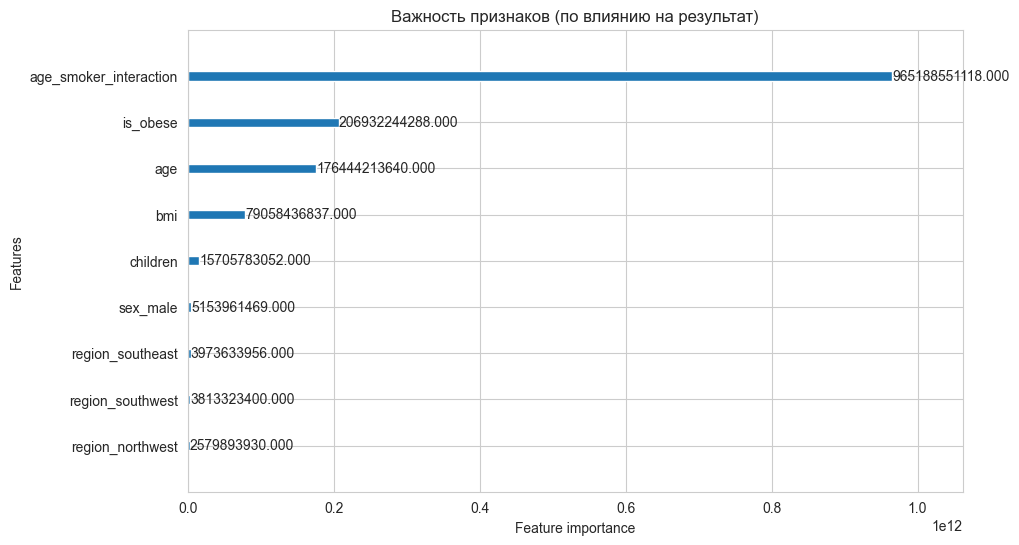

In [ ]:
# 5.3. Анализ важности признаков
# Визуализирую, какие признаки модель считает наиболее влиятельными
lgb.plot_importance(
    best_model, 
    figsize=(10, 6), 
    importance_type='gain', 
    title='Важность признаков (по влиянию на результат)'
)
plt.show()

In [ ]:
# 5.4. Сравнение с базовой моделью (Линейная регрессия)

# Масштабирую данные, так как линейные модели чувствительны к масштабу признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучаем модель
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Итоговое сравнение моделей
print("\n" + "="*50 + "\n")
print("--- Сравнительные результаты моделей ---")

# Результаты для Линейной регрессии
y_pred_lr = lr_model.predict(X_test_scaled)
r2_lr = r2_score(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
print(f"Линейная регрессия: R2 = {r2_lr:.4f}, MAE = ${mae_lr:,.2f}")

# Результаты для нашего лучшего LightGBM
y_pred_lgbm = best_model.predict(X_test)
r2_lgbm = r2_score(y_test, y_pred_lgbm)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
print(f"Оптимизированный LightGBM: R2 = {r2_lgbm:.4f}, MAE = ${mae_lgbm:,.2f}")



--- Сравнительные результаты моделей ---
Линейная регрессия: R2 = 0.7838, MAE = $4,266.39
Оптимизированный LightGBM: R2 = 0.8763, MAE = $2,502.03


### 6. Глубокая интерпретация лучшей модели (SHAP)

--- График общего влияния признаков (SHAP Summary Plot) ---


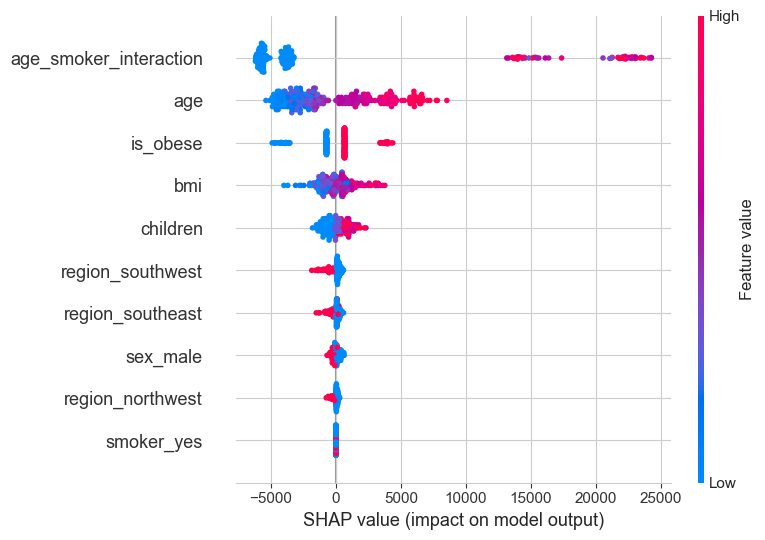

In [ ]:
# Инициализирую объяснитель SHAP для нашей модели
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# График общего влияния признаков
print("--- График общего влияния признаков (SHAP Summary Plot) ---")
shap.summary_plot(shap_values, X_test)

In [13]:
# Объяснение прогноза для одного конкретного клиента (первого в тестовой выборке)
print("\n--- Объяснение прогноза для одного клиента (SHAP Force Plot) ---")
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])


--- Объяснение прогноза для одного клиента (SHAP Force Plot) ---


### 7. Создание и сохранение финального пайплайна

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
import joblib

# 1. Создаю функцию для Feature Engineering
def add_features(df_):
    df = df_.copy() # Работаю с копией, чтобы не изменять исходные данные
    df['is_obese'] = (df['bmi'] > 30).astype(int)
    df['smoker_numeric'] = df['smoker'].map({'yes': 1, 'no': 0})
    df['age_smoker_interaction'] = df['age'] * df['smoker_numeric']
    df = df.drop('smoker_numeric', axis=1)
    return df

# Оборачиваю нашу функцию в FunctionTransformer
feature_adder = FunctionTransformer(add_features)


# 2. Обновляю списки признаков для препроцессора 
# Теперь в числовые признаки нужно добавить те, что создал
numeric_features = ['age', 'bmi', 'children', 'is_obese', 'age_smoker_interaction']
categorical_features = ['sex', 'smoker', 'region']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
    ])


# 3. Создаю финальный пайплайн с тремя шагами
final_pipeline = Pipeline(steps=[
    ('feature_engineering', feature_adder), # ШАГ 1: Добавляю признаки
    ('preprocessor', preprocessor),          # ШАГ 2: Предобрабатываю
    ('regressor', best_model)                # ШАГ 3: Делаю предсказание
])


# 4. Обучаю и сохраняю пайплайн
# Пайплайн будет принимать на вход "сырой" df
final_pipeline.fit(df.drop('charges', axis=1), df['charges'])
print("Финальный пайплайн успешно создан и обучен!")

filename = 'insurance_model.joblib'
joblib.dump(final_pipeline, filename)
print(f"\nМодель сохранена в файл: {filename}")


# 5. Пример использования
# Создаю нового клиента
new_client_data = {
    'age': 27,# Указать возраст
    'sex': 'male',# Пол
    'bmi': 31.5,
    'children': 1,# Кол детей на моем примере 1
    'smoker': 'yes',# Курит или нет
    'region': 'southeast'
}
new_client_df = pd.DataFrame([new_client_data])

# Загружаю и использую готовый пайплайн
loaded_model = joblib.load(filename)
prediction = loaded_model.predict(new_client_df)

print(f"\nПрогноз стоимости страховки для нового клиента: ${prediction[0]:,.2f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 1338, number of used features: 10
[LightGBM] [Info] Start training from score 13270.422260
Финальный пайплайн успешно создан и обучен!

Модель сохранена в файл: insurance_model.joblib

Прогноз стоимости страховки для нового клиента: $35,086.21
